In [6]:
# Required Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

# Load dataset
df = pd.read_csv("C:/Users/Shubham kumar/Downloads/transactions_large.csv") 
# Display first few rows
df.head()


,InvoiceNo,Item
0,1001,cola
1,1001,cheese
2,1002,cheese
3,1002,eggs
4,1002,butter


In [7]:
# Drop missing values
df.dropna(inplace=True)

# Check for duplicates
df.drop_duplicates(inplace=True)

# Ensure consistent casing
df['Item'] = df['Item'].str.strip().str.lower()


In [8]:
# Convert invoice to transaction list
transactions = df.groupby('InvoiceNo')['Item'].apply(list).tolist()

# Transaction encoding
encoder = TransactionEncoder()
encoded = encoder.fit(transactions).transform(transactions)
basket_df = pd.DataFrame(encoded, columns=encoder.columns_)


In [11]:
# Check for column types and validate encoding
print(basket_df.dtypes.value_counts())

# Check if all values are Boolean
# Ensure all values are boolean
assert basket_df.apply(lambda col: col.map(lambda x: isinstance(x, bool))).all().all()



bool    10
Name: count, dtype: int64


In [12]:
item_counts = basket_df.sum().sort_values(ascending=False)

# Top 10 items
item_counts.head(10)


butter     327
cola       323
diapers    313
beer       309
bread      306
cheese     298
milk       298
eggs       289
chips      287
cookies    283
dtype: int64

In [13]:
frequent_items = apriori(basket_df, min_support=0.02, use_colnames=True)

# Association rules
rules = association_rules(frequent_items, metric='lift', min_threshold=1)
rules.sort_values('lift', ascending=False).head(10)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
79,(beer),"(chips, cola)",0.309,0.086,0.035,0.113269,1.317077,1.0,0.008426,1.030752,0.348398,0.097222,0.029834,0.260123
78,"(chips, cola)",(beer),0.086,0.309,0.035,0.406977,1.317077,1.0,0.008426,1.165216,0.263395,0.097222,0.141790,0.260123
60,(butter),"(beer, cola)",0.327,0.100,0.043,0.131498,1.314985,1.0,0.010300,1.036268,0.355921,0.111979,0.034998,0.280749
57,"(beer, cola)",(butter),0.100,0.327,0.043,0.430000,1.314985,1.0,0.010300,1.180702,0.266150,0.111979,0.153046,0.280749
216,"(milk, cheese)",(eggs),0.089,0.289,0.033,0.370787,1.282998,1.0,0.007279,1.129982,0.242125,0.095652,0.115030,0.242487
221,(eggs),"(milk, cheese)",0.289,0.089,0.033,0.114187,1.282998,1.0,0.007279,1.028434,0.310233,0.095652,0.027647,0.242487
218,"(cheese, eggs)",(milk),0.088,0.298,0.033,0.375000,1.258389,1.0,0.006776,1.123200,0.225146,0.093484,0.109687,0.242869
219,(milk),"(cheese, eggs)",0.298,0.088,0.033,0.110738,1.258389,1.0,0.006776,1.025570,0.292498,0.093484,0.024932,0.242869
156,"(bread, cola)",(milk),0.097,0.298,0.036,0.371134,1.245416,1.0,0.007094,1.116295,0.218223,0.100279,0.104180,0.245970
161,(milk),"(bread, cola)",0.298,0.097,0.036,0.120805,1.245416,1.0,0.007094,1.027076,0.280706,0.100279,0.026363,0.245970


In [14]:
# Remove very rare items
basket_df = basket_df.loc[:, basket_df.sum() > 10]

# Normalize if required (not common in MBA, but shown here)
basket_df = basket_df.astype(int)


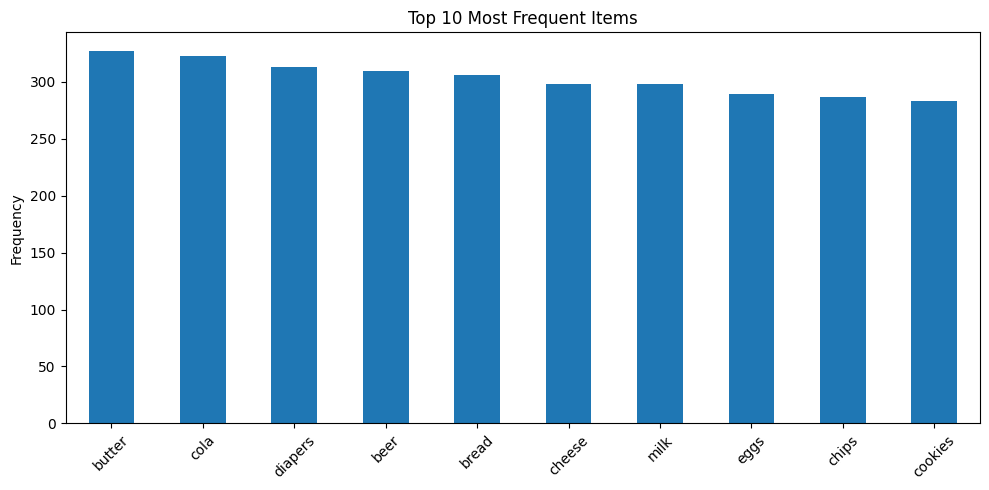

In [16]:
import os

# Create directory if it doesn't exist
os.makedirs("outputs/visuals", exist_ok=True)

# Plot
plt.figure(figsize=(10,5))
item_counts.head(10).plot(kind='bar')
plt.title("Top 10 Most Frequent Items")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("outputs/visuals/item_frequency.png")
plt.show()


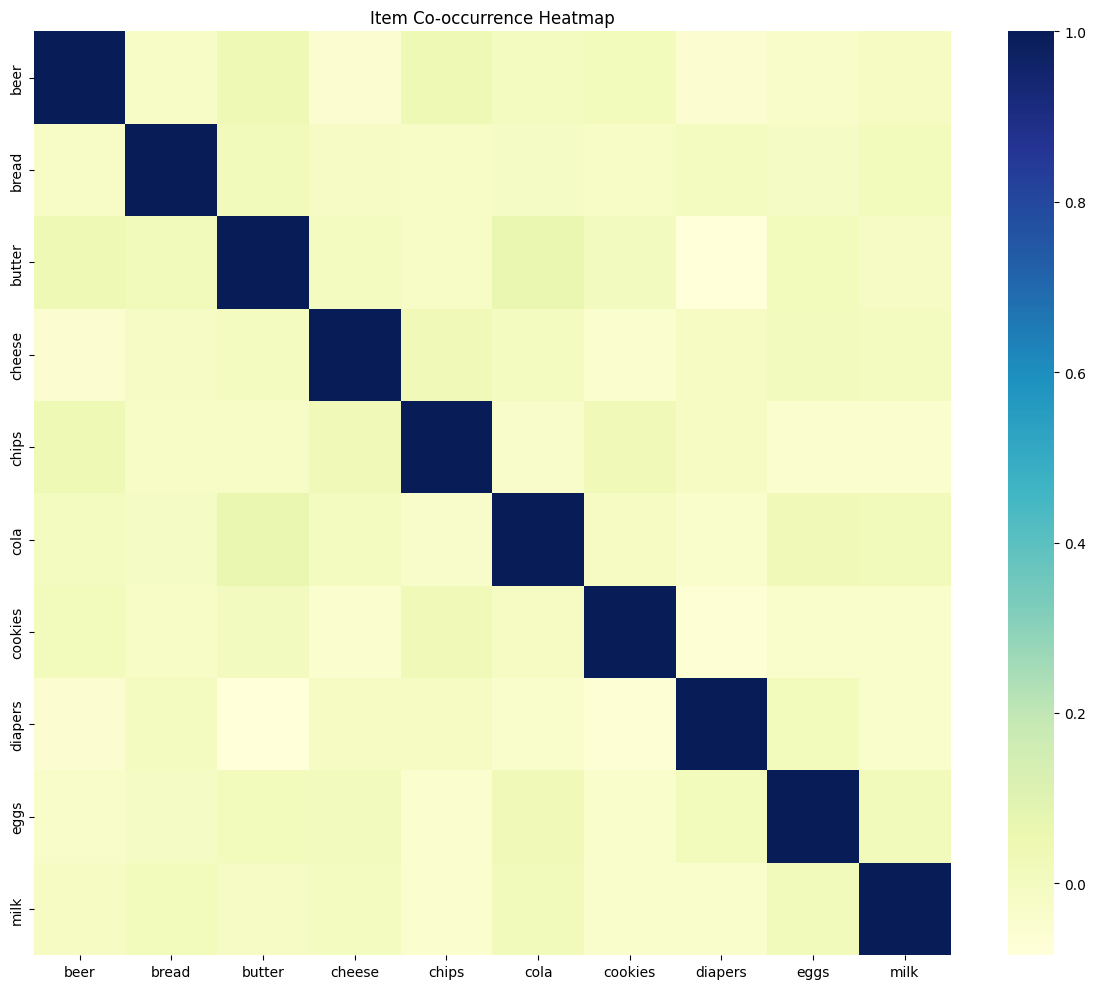

In [17]:
co_matrix = basket_df.corr()
plt.figure(figsize=(12,10))
sns.heatmap(co_matrix, cmap="YlGnBu")
plt.title("Item Co-occurrence Heatmap")
plt.tight_layout()
plt.savefig("outputs/visuals/heatmap.png")
plt.show()


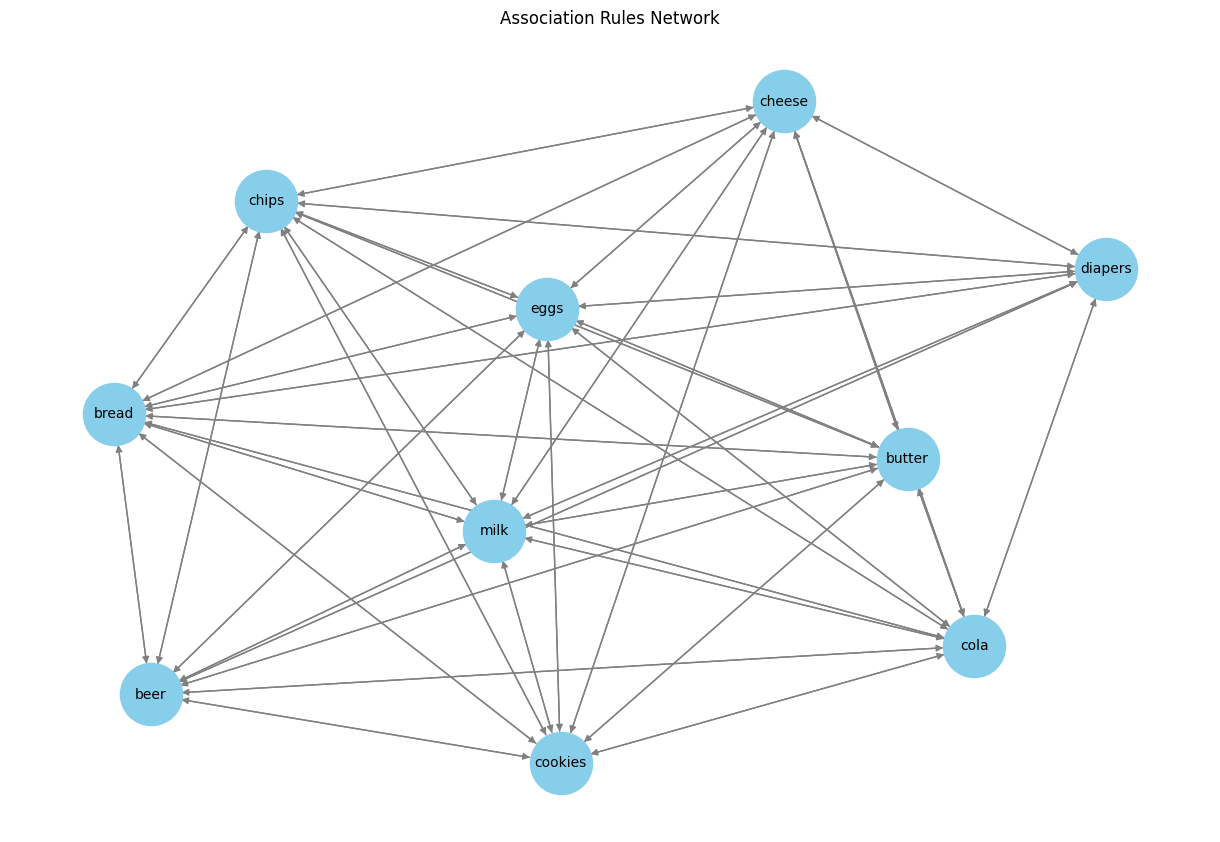

In [18]:
import networkx as nx

G = nx.DiGraph()

for _, row in rules.iterrows():
    for antecedent in row['antecedents']:
        for consequent in row['consequents']:
            G.add_edge(antecedent, consequent, weight=row['lift'])

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=2)
nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=2000, font_size=10)
plt.title("Association Rules Network")
plt.savefig("outputs/visuals/network_graph.png")
plt.show()
